In [1]:
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
import pandas as pd
import time
import json
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
%matplotlib inline

In [2]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)


wiki = pd.read_csv('people_wiki.csv')
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [3]:
with open('people_wiki_map_index_to_word.json') as people_wiki_map_index_to_word:    
    map_index_to_word = json.load(people_wiki_map_index_to_word)

In [4]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

In [5]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [6]:
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(dist)

[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]


In [7]:
queries = tf_idf[:3, :]
dist_matrix = pairwise_distances(tf_idf, queries, metric='euclidean')

dist = dist_matrix[430, 1]

In [8]:
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [9]:
closest_cluster = np.argmin(dist_matrix, axis=1)

In [10]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in dist_matrix]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [11]:
cluster_assignment = closest_cluster

In [12]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [13]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [14]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


In [15]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [16]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)

[0 1 0]


In [19]:
cluster_assignment==1

array([False,  True, False])

In [20]:
cluster_assignment==0

array([ True, False,  True])

In [17]:
print(data[cluster_assignment==1])

[[0. 0. 0.]]


In [21]:
print(data[cluster_assignment==0])

[[1. 2. 0.]
 [2. 2. 0.]]


In [23]:
print(data[cluster_assignment==0].mean(axis=0))

[1.5 2.  0. ]


In [24]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment == i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [25]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [26]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [27]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

In [28]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [29]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

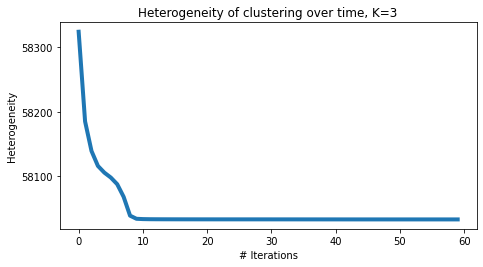

In [30]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [31]:
print(True)

True


In [32]:
print(4)

4


In [34]:
np.argmax(np.bincount(cluster_assignment))

2

In [36]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print(np.bincount(cluster_assignment))
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

[18047  3824  5671  6983  1492  1730  3882  3449  7139  6854]
seed=000000, heterogeneity=57457.52442
[ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485]
seed=020000, heterogeneity=57533.20100
[ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132]
seed=040000, heterogeneity=57512.69257
[ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900]
seed=060000, heterogeneity=57466.97925
[17582  1785  7215  3314  6285   809  5930  6791  5536  3824]
seed=080000, heterogeneity=57494.92990
[ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387]
seed=100000, heterogeneity=57484.42210
[ 6118  5841  4964  8423  4302  3183 16481  1608  5524  2627]
seed=120000, heterogeneity=57554.62410
156.62629389762878


In [37]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [38]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
195.95601415634155


TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

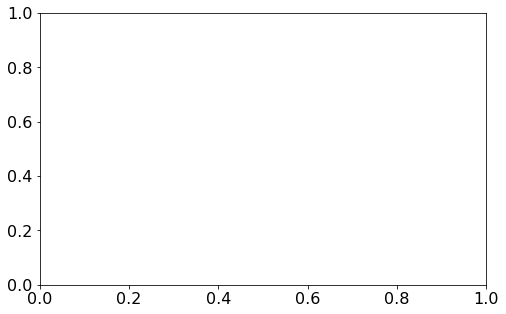

In [39]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [40]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter=400, record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

In [41]:
#def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
#    plt.figure(figsize=(7,4))
#    plt.plot(k_values, heterogeneity_values, linewidth=4)
#    plt.xlabel('K')
#    plt.ylabel('Heterogeneity')
#    plt.title('K vs. Heterogeneity')
#    plt.rcParams.update({'font.size': 16})
#    plt.tight_layout()

#start = time.time()
#centroids = {}
#cluster_assignment = {}
#heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

#for k in k_list:
#    heterogeneity = []
#    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
#                                                               num_runs=len(seed_list),
#                                                               seed_list=seed_list,
#                                                               verbose=True)
#    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
#    heterogeneity_values.append(score)

#plot_k_vs_heterogeneity(k_list, heterogeneity_values)

#end = time.time()
#print(end-start)

2
10
25
50
100


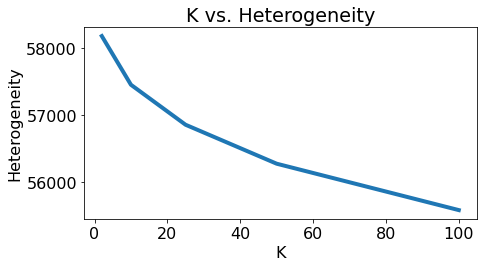

In [43]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print(k)
        sys.stdout.flush()
        '''To save memory space, do not load the arrays from the file right away. We use
           a technique known as lazy evaluation, where some expressions are not evaluated
           until later. Any expression appearing inside a lambda function doesn't get
           evaluated until the function is called.
           Lazy evaluation is extremely important in memory-constrained setting, such as
           an Amazon EC2 t2.micro instance.'''
        centroids[k] = lambda k=k: arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = lambda k=k: arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [45]:
map_index_to_word = pd.DataFrame(map_index_to_word.items(), columns=['category', 'index'])

In [51]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word['category'][idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [52]:
visualize_document_clusters(wiki, tf_idf, centroids[2](), cluster_assignment[2](), 2, map_index_to_word)

Cluster 0    
serieslong:0.025
bostonas:0.017
33story:0.012
gan:0.011
efovi:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda               

In [69]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0    
allmvfc:0.020
scientistagreed:0.014
gan:0.011
psihomodo:0.010
2001pasithee:0.010


* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823


* Todd Curley                                        0.92731
  todd curley born 14 january 1973 is a former australian rules footballer who played for co
  llingwood and the western bulldogs in the australian football league

* Ashley Prescott                                    0.92992
  ashley prescott born 11 september 1972 is a former australian rules footballer he played w
  ith the richmond and fremantle football clubs in the afl between

* Pete Richardson                                    0.93204
  pete richardson born october 17 1946 in youngstown ohio is a former american football defe
  nsive back in the national football league and former college head

* Nathan Brown (Australian footballer born 1976)     0.93561
  nathan daniel brown born 14 august 1976 is an australian rules footballer who played for t
  he melbourne demons in the australian football leaguehe was drafted

* Earl Spalding                                      0.93654
  earl spalding born 11 march 1965 in sou

In [70]:
np.argmax(np.bincount(cluster_assignment[10]()))

0

In [71]:
np.argmin(np.bincount(cluster_assignment[10]()))

8

In [72]:
np.bincount(cluster_assignment[10]())

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,
        8926])

In [59]:
k = 25
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0    
blitzattack:0.077
addie:0.048
recordingstheir:0.046
buntingfrom:0.038
hettingers:0.038


* George B. Daniels                                  0.92779
  george benjamin daniels born 1953 is a united states federal judge for the united states d
  istrict court for the southern district of new yorkdaniels was

* William G. Young                                   0.92867
  william glover young born 1940 is a united states federal judge for the district of massac
  husetts young was born in huntington new york he attended

* Jean Constance Hamilton                            0.92969
  jean constance hamilton born 1945 is a senior united states district judge of the united s
  tates district court for the eastern district of missouriborn in

* Barry Sullivan (lawyer)                            0.92991
  barry sullivan is a chicago lawyer and as of july 1 2009 the cooney conway chair in advoca
  cy at loyola university chicago school of law

* James G. Carr                      

lopilato:0.160
madeamhali:0.056
1200in:0.044
zahida:0.043
pricepottenger:0.042


* Snyder Rini                                        0.89987
  snyder rini born 27 july 1949 is a solomon islands politician who was briefly the eighth p
  rime minister of the solomon islands from april to

* William Haomae                                     0.90011
  william nii haomaepia born november 26 1960 is a politician of the solomon islands who has
   been minister for foreign affairs and external trade since

* Mohlabi Tsekoa                                     0.90660
  mohlabi kenneth tsekoa born 13 august 1945 is the minister of foreign affairs of lesotho h
  e has served in the cabinet since july 2001 first

* Monique Landry                                     0.90707
  monique landry pc born december 25 1937 is a former canadian politician a physiotherapist 
  and administrator she was first elected to the canadian house of

* Carmel Zollo                                       0.90722
  ca


* Krisztina Papp                                     0.90105
  krisztina papp born 17 december 1982 in eger is a hungarian long distance runner she is th
  e national indoor record holder over 5000 mpapp began

* Heather Samuel                                     0.90128
  heather barbara samuel born 6 july 1970 is a retired sprinter from antigua and barbuda who
   specialized in the 100 and 200 metres in 1990

* Alessandra Aguilar                                 0.90499
  alessandra aguilar born 1 july 1978 in lugo is a spanish longdistance runner who specialis
  es in marathon running she represented her country in the event

* Ayelech Worku                                      0.90524
  ayelech worku born june 12 1979 is an ethiopian longdistance runner most known for winning
   two world championships bronze medals on the 5000 metres she

* Viola Kibiwot                                      0.90693
  viola jelagat kibiwot born december 22 1983 in keiyo district is a runner from ke


* Scott McMahon                                      0.90273
  scott mcmahon born 2 june 1986 is an australian rules football player currently on the ros
  ter of australian football league afl club north melbourne kangaroosmcmahon

* Steven Browne                                      0.90288
  steven browne born 1 february 1989 is an australian rules footballer who played for the ca
  rlton football club in the australian football league afl from

* Nick Salter                                        0.90318
  nick salter born 30 july 1987 is an australian rules footballer who played for port adelai
  de football club in the australian football league aflhe was

* Todd Curley                                        0.90348
  todd curley born 14 january 1973 is a former australian rules footballer who played for co
  llingwood and the western bulldogs in the australian football league

* Richard Ambrose                                    0.90420
  richard ambrose born 10 june 1972 is a 


* Keith Urban                                        0.94716
  keith lionel urban born 26 october 1967 is a new zealand born australian country music sin
  ger songwriter guitarist entrepreneur and music competition judge in 1991

* Will.i.am                                          0.94819
  william adams born march 15 1975 known by his stage name william pronounced will i am is a
  n american rapper songwriter entrepreneur actor dj record

* Tony Mills (musician)                              0.94879
  tony mills born 7 july 1962 in solihull england is an english rock singer best known for h
  is work with shy and tnthailing from birmingham

* Steve Overland                                     0.94983
  steve overland is a british singermusician who was the lead vocalist and songwriter for th
  e bands wildlife fm the ladder shadowman and his own group

* Prince (musician)                                  0.95198
  prince rogers nelson born june 7 1958 known by his mononym prince is 

In [60]:
k = 100
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0    
isolates:0.137
zincavage:0.082
asiabased:0.056
pantherslabowitch:0.053
machairitsas:0.050


* Alexander Kellner                                  0.92522
  alexander wilhelm armin kellner vaduz 26 september 1961 is a brazilian paleontologist a le
  ading expert in the field of the study of pterosaursalexander kellner was

* Marcelo Gon%C3%A7alves Costa Lopes                 0.92694
  marcelo gonalves costa lopes usually known simply as gonalves born on february 22 1966 in 
  rio de janeiro rio de janeiro state is a brazilian

* S%C3%A9rgio de Queiroz Duarte                      0.92736
  sergio de queiroz duarte born 1934 in rio de janeiro brazil is a former brazilian diplomat
   his last position was as united nations high representative

* Werner Baer                                        0.93218
  werner baer born 1931 is an american economist at the university of illinois urbanachampai
  gn and the jorge lemann professor of economics he received his bachelors

* Jo%C3


* Marcy Kahan                                        0.85710
  marcy kahan born 4 july is a british playwright and radio dramatist who is halfcanadian an
  d halfamerican she is a prolific author of urbane comedies

* Babita Sharma                                      0.86646
  babita sharma is a british television newsreader currently fronting the overnight bulletin
  s on the bbc news and bbc world news presenting the newsday strand each

* John Forrest (producer)                            0.87004
  references songs of praisearticle in the jewish chronicles re the insight film festivaljoh
  nforresttvjohn forrest is a uk production creative who has made significant contributions 

* Roy Calley                                         0.87130
  roy calley is an english journalist he works for the bbc in salford but was brought up in 
  blackpool lancashirehe joined the bbc in 1990

* Francis Collings                                   0.87296
  francis collings is a former bbc journal


* Peter Haining (rower)                              0.81630
  peter moir haining born 3 april 1962 is a former scottish rower and three times world ligh
  tweight sculling championhaining was born at dumbarton scotland the

* Bebe Bryans                                        0.82088
  bebe bryans born 1957 is a united states national champion in rowing and former coach of t
  he united states womens national rowing crew she is

* James Clark (rower)                                0.83200
  james jim clark born 15 july 1950 is a british rower who competed in the 1972 summer olymp
  ics in the 1976 summer olympics and in

* Kathy Keeler                                       0.83366
  kathryn elliott kathy keeler born november 3 1956 in galveston texas is a former american 
  competitive rower and olympic gold medalist she was a member

* Hugh Matheson (rower)                              0.83862
  hugh patrick matheson born 16 april 1949 at ormiston near hawick scotland is a british r


* Dave Ford                                          0.84619
  david alan ford born december 29 1956 is a former major league baseball pitcher for the ba
  ltimore orioles born in cleveland ohio ford attended lincolnwest

* Donnie Elliott                                     0.87927
  donald glenn elliott born september 20 1968 in pasadena texas is a former righthanded majo
  r league baseball relief pitcher who played from 1994 to 1995

* Chris S%C3%A1enz                                   0.88627
  christopher andrew senz born august 8 1981 in tucson arizona is a former professional base
  ball pitcher senz appeared in one major league baseball game with

* Mitch Lively                                       0.88777
  mitchell david lively born september 7 1985 is an american professional baseball pitcher c
  urrently in the washington nationals minor league systemhe was born in susanville

* Dom Zanni                                          0.88904
  dominick thomas zanni born march 


* Jim Ferguson                                       0.86972
  jim ferguson born james edwin ferguson 1948 is an american guitarist composer music educat
  or author and music journalisteditorborn in dayton ohio jim ferguson began his

* Todd Grubbs                                        0.90453
  todd grubbs is an american rockfusion guitarist and composer primarily of complex and melo
  dic instrumental musicgrubbs is from tampa florida and studied at berklee college

* Steve Lynch                                        0.91575
  steve lynch born 1955 seattle washington is an american hard rockheavy metal guitarist als
  o known as the twohanded guitarist as well as a guitar instructor

* Scott Tennant                                      0.91782
  scott tennant is a grammy awardwinning american classical guitarist he is a member of the 
  los angeles guitar quartet and is the author of the

* Jang Daekun                                        0.91939
  daekun jang is a young korean


* Scott McMahon                                      0.84452
  scott mcmahon born 2 june 1986 is an australian rules football player currently on the ros
  ter of australian football league afl club north melbourne kangaroosmcmahon

* Peter Faulks                                       0.84550
  peter faullks born 24 april 1988 is an australian rules footballer for the fremantle footb
  all club in the australian football league afl and the peel

* Steven Browne                                      0.84761
  steven browne born 1 february 1989 is an australian rules footballer who played for the ca
  rlton football club in the australian football league afl from

* Carl Peterson (Australian footballer)              0.84772
  carl peterson born 3 july 1987 is an australian rules footballer who formerly played in th
  e australian football league afl with the hawthorn football clubpeterson

* Alan Obst                                          0.84798
  alan obst is an australian rules foo


* Road Dogg                                          0.74740
  brian girard bg james born may 20 1969 is an american professional wrestler and former uni
  ted states marine currently signed to the wwe james returned

* T. Rantula                                         0.77816
  david younkins born march 30 1962 better known by his ring name t rantula is a semiretired
   american professional wrestler trainer and promoter he was

* Maverick Wild                                      0.79566
  scott cameron despres born september 4 1970 is an american professional wrestler trainer a
  nd promoter known by the ring name maverick wild he was one

* Drew McIntyre                                      0.80166
  andrew drew galloway born 6 june 1985 is a scottish professional wrestler best known for h
  is tenure with wwe under the ring name drew mcintyre

* Jacqueline Moore                                   0.81277
  jacqueline delois moore born january 6 1964 is a semiretired american prof


* Mehdi Jazayeri                                     0.91435
  mehdi jazayeri is the founding dean of the faculty of informatics of the universit della s
  vizzera italiana university of lugano in lugano switzerland and author

* Bruce Shriver                                      0.91545
  bruce shriver is a computer science academic and a consultant and entrepreneur in the area
   of highperformance computer systems shriver received his phd in computer

* Bruce Arden                                        0.92698
  bruce wesley arden born in 1927 in minneapolis minnesota is an american computer scientist
  he graduated from purdue university with a bsee in 1949 and started

* Jack Dennis                                        0.93160
  jack bonnell dennis is a computer scientist and emeritus professor of computer science and
   engineering at mitdennis graduated from the massachusetts institute of technology mit

* Hank Levy (computer scientist)                     0.93476
  henry m 


* Laurie Richards                                    0.87800
  laurie james richards born 14 january 1947 is a former australian rules footballer who pla
  yed with west perth in the western australian national football league

* Mark Buckley                                       0.88017
  mark buckley born 25 august 1962 is a former australian rules footballer who played with c
  arlton st kilda and the brisbane bears in the victorian

* John Fidge                                         0.88311
  john fidge born 4 may 1966 is a former australian rules footballer who played with melbour
  ne and the brisbane bears in the victorian football league

* Peter Freeman (footballer)                         0.88684
  peter freeman born 1 april 1969 is a former australian rules footballer who played for the
   st kilda football club in the victorian football league

* Bret Hutchinson                                    0.88712
  bret hutchinson born 6 march 1964 is a former australian rules fo


* Fiona Kelleghan                                    0.89904
  fiona kelleghan born west palm beach florida 21 april 1965 is an american academic and cri
  tic specializing in science fiction and fantasy she was a

* Kit Reed                                           0.90171
  kit reed is an american author of both speculative fiction and literary fiction as well as
   psychological thrillers under the pseudonym kit craigreed was born

* Richard Bowes                                      0.90702
  richard bowes is an american author of science fiction and fantasyrichard bowes was born i
  n boston in 1944 he attended school both in boston and

* Bertil M%C3%A5rtensson                             0.90895
  bertil mrtensson born 1945 in malm now living in helsingborg is a swedish author of scienc
  e fiction crime fiction and fantasy and also an academic

* Andrew Sawyer                                      0.91527
  andrew andy sawyer born 1952 is a librarian critic and editor as well 


* Gayle Dean Wardlow                                 0.87329
  gayle dean wardlow born august 31 1940 is an american historian of the blues he is particu
  larly associated with research into the lives of musicians

* Zora Young                                         0.88042
  zora young born january 21 1948 west point mississippi united states is an american blues 
  singer she is a distant relative of howlin wolfyoungs family

* Harpdog Brown                                      0.88118
  harpdog brown is a singer and harmonica player who has been active in canadas blues scene 
  since 1982 hailing from vancouver he crossed tens of

* Guido van Rijn                                     0.88725
  guido van rijn 11 april 1950 is a dutch blues and gospel historianvan rijn received his ph
  d from leiden university in 1995 for roosevelts blues

* Forrest Howard McDonald                            0.88904
  forrest howard mcdonald born april 22 1950 is an american blues rock musician who


* William G. Young                                   0.88328
  william glover young born 1940 is a united states federal judge for the district of massac
  husetts young was born in huntington new york he attended

* Barry Sullivan (lawyer)                            0.88573
  barry sullivan is a chicago lawyer and as of july 1 2009 the cooney conway chair in advoca
  cy at loyola university chicago school of law

* George B. Daniels                                  0.88660
  george benjamin daniels born 1953 is a united states federal judge for the united states d
  istrict court for the southern district of new yorkdaniels was

* Bernard Bell (attorney)                            0.88769
  bernard bell is the associate dean for academic affairs and faculty professor of law and h
  erbert hannoch scholar at rutgers school of lawnewark bell received

* James G. Carr                                      0.89502
  james g carr born july 7 1940 is a federal district judge for the united 


* Lawrence W. Green                                  0.88770
  lawrence w green is best known by health education researchers as the originator of the pr
  ecede model and codeveloper of the precedeproceed model which has

* Robert Isaac Field                                 0.91008
  robert i field chairs the department of health policy and public health at university of t
  he sciences in philadelphia his research and publications cover many

* Howard Koh                                         0.91058
  howard kyongju koh hangul hanja born march 15 1952 is the former united states assistant s
  ecretary for health for the us department of health and

* Harvey V. Fineberg                                 0.91868
  harvey fineberg is a former president of the institute of medicine he served as provost of
   harvard university from 1997 to 2001 following thirteen years

* Tony Jewell (doctor)                               0.92048
  john anthony tony jewell ma frcgp ffph born 6 may 1950


* Jean-Fran%C3%A7ois Simard                          0.83788
  jeanfranois simard born december 10 1966 is a teacher and former quebec provincial politic
  ian and cabinet minister he was the a member of the national

* Alain Paquet                                       0.85076
  alain paquet born april 17 1961 in quebec city quebec is a quebec politician teacher and e
  conomist he was a member of national assembly of

* Jacques-Yvan Morin                                 0.85104
  jacquesyvan morin goq born july 15 1931 in quebec city quebec was professor of law and a p
  olitician in quebec canada morin graduated from the

* Catherine Morissette                               0.85485
  catherine morissette born february 3 1979 in quebec city quebec is a politician and lawyer
   from quebec canada she was an action dmocratique du qubec

* Michelle Courchesne                                0.85502
  michelle courchesne born may 6 1953 in troisrivires quebec is a former deputy premier o

modellinghe:0.048
13millionsquarefoot:0.047
meadowhall:0.043
2001pasithee:0.038
namadi:0.037


* Bryan Cranston                                     0.95164
  bryan lee cranston born march 7 1956 is an american actor voice actor screenwriter directo
  r and producer he is known for portraying walter white in

* Jenny Funnell                                      0.95401
  jenny funnell born 20 may 1963 is a british actress best known for her role as sandy in th
  e british sitcom as time goes by

* Matt Jones (writer)                                0.95422
  matthew david jones born 5 august 1968 is a british television writer and television produ
  cer who has worked on a variety of popular drama programmes

* Elen Willard                                       0.95555
  elen willard born september 1 1941 is a former american character actress who worked in am
  erican network dramatic television series between 1960 and 1966miss willards

* Clive Mantle                                   


* Clare Wood                                         0.90218
  clare jacqueline wood born 8 march 1968 in zululand district municipality natal province s
  outh africa is a former british number 1 tennis player from great

* Jorge Lozano                                       0.90932
  jorge lozano born 17 may 1963 in san luis potos is a retired professional tennis player fr
  om mexico he reached his highest doubles ranking of

* Doris Hart                                         0.90951
  doris hart born on june 20 1925 is a former world no 1 american tennis playeras a child sh
  e suffered from osteomyelitis which resulted in

* Daniel Nestor                                      0.91479
  daniel mark nestor cm born september 4 1972 in belgrade sfr yugoslavia is a canadian profe
  ssional tennis player from toronto ontario he is one of

* Pam Teeguarden                                     0.91490
  pam teeguarden born april 17 1951 is a former american professional tennis player in t


* Tom Cruise                                         0.95776
  tom cruise born thomas cruise mapother iv july 3 1962 is an american actor and filmmaker h
  e has been nominated for three academy awards and

* Grant Cramer                                       0.95951
  grant cramer born november 10 1961 is an american actor and producer who has starred in fi
  lms and on television he is the son of

* Ted Childs                                         0.96002
  ted childs commenced training as a programme director with abc television in 1962 he went 
  on to produce and direct a wide variety of factual

* Clint Eastwood                                     0.96105
  clinton clint eastwood jr born may 31 1930 is an american actor director producer musician
   and politician he rose to international fame with his role

* Michael Armstrong (cinematographer)                0.96167
  michael armstrong born 24 july 1944 bolton lancashire england is a british writer and dire
  ctorarmstrong t


* Claude M. Kicklighter                              0.89250
  claude m kicklighter born august 22 1933 is a retired american army lieutenant general he 
  is a former commander of the united states army western

* Johnnie H. Corns                                   0.89526
  john herman corns born march 21 1936 was a lieutenant general in the united states army wh
  o served as commander of united states army pacific

* Robert Mark Brown                                  0.89697
  brigadier general mark brown is the commanding general soldier systems center ssc natick m
  assachusetts and the program executive office peo soldier headquartered at fort belvoir

* Robert T. Clark                                    0.89781
  lieutenant general robert t clark is a retired united states army general his last assignm
  ent was as the commanding general fifth united states army later

* Robert L. Ord, III                                 0.89917
  robert laird ord iii born may 12 1940 was a lie

In [68]:
contador=0
for i in np.bincount(cluster_assignment[100]()) < 236:
    if i == True:
        contador += 1

contador

29